<a href="https://colab.research.google.com/github/simha13/Tomato-Leaf-Disease-Prediction/blob/main/Tomato_Disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).



### **Importing Dependencies**

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [4]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


### **Setting Constants**

In [5]:
BATCH_SIZE = 30
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=45

### **Import data into tensorflow dataset object**

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4500 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
class_names

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(30, 256, 256, 3)
[1 1 2 1 0 2 2 2 1 0 2 1 1 1 1 1 0 0 2 1 2 2 2 2 1 1 1 1 0 1]



### **Visualize some of the images from our dataset**

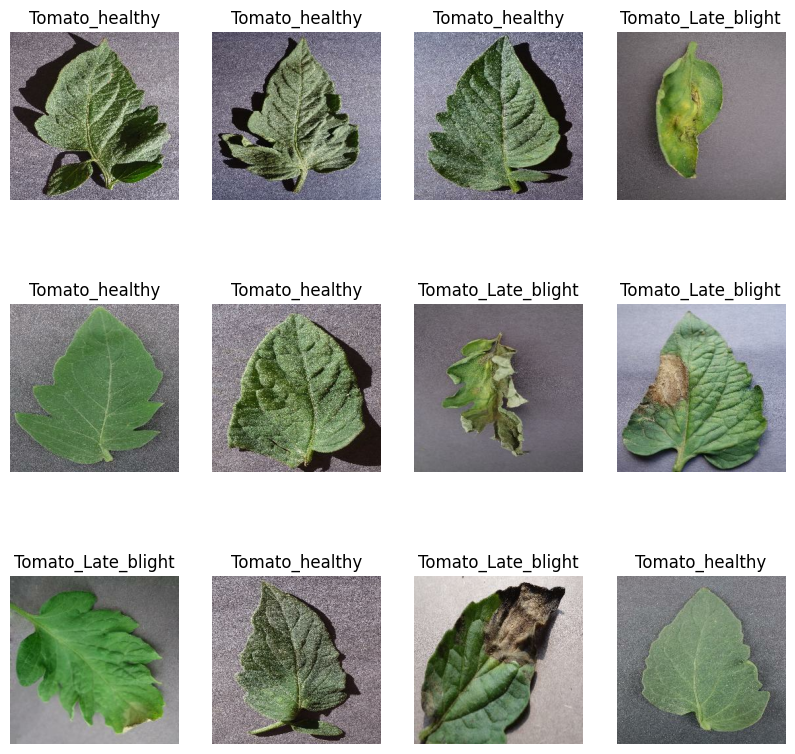

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### **Function to Split Dataset**

Dataset should be bifurcated into 3 subsets, namely:

   1) Training: Dataset to be used while training

   2) Validation: Dataset to be tested against while training
   
   3) Test: Dataset to be tested against after we trained a model


In [10]:
len(dataset)

150

In [11]:
train_size = 0.8
len(dataset)*train_size

120.0

In [12]:
train_ds = dataset.take(120)
len(train_ds)

120

In [13]:
test_ds = dataset.skip(120)
len(test_ds)

30

In [14]:
val_size=0.1
len(dataset)*val_size

15.0

In [15]:
val_ds = test_ds.take(15)
len(val_ds)

15

In [16]:
test_ds = test_ds.skip(15)
len(test_ds)

15

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

120

In [20]:
len(val_ds)

15

In [21]:
len(test_ds)

15

### **Cache, Shuffle, and Prefetch the Dataset**

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### **Building the Model**
*Creating a Layer for Resizing and Normalization*

In [23]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### **Data Augmentation**

In [24]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

*Applying Data Augmentation to Train Dataset*

In [25]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### **Model Architecture**

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

with tf.device(device_name):
  model = models.Sequential([
      resize_and_rescale,
      layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(64, (3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(64, (3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(64, (3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),
      layers.Flatten(),
      layers.Dense(64, activation='relu'),
      layers.Dense(n_classes, activation='softmax'),
  ])

  model.build(input_shape=input_shape)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (30, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (30, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (30, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (30, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (30, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (30, 60, 60, 64)         

### **Compiling the Model**

In [28]:
with tf.device(device_name):
  model.compile(
      optimizer='adam',
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
      metrics=['accuracy']
  )

In [29]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=45,
)

Epoch 1/45
120/120 [==============================] - 52s 317ms/step - loss: 0.9615 - accuracy: 0.5086 - val_loss: 0.6450 - val_accuracy: 0.7156
Epoch 2/45
120/120 [==============================] - 33s 273ms/step - loss: 0.5927 - accuracy: 0.7297 - val_loss: 0.5526 - val_accuracy: 0.7489
Epoch 3/45
120/120 [==============================] - 32s 264ms/step - loss: 0.4447 - accuracy: 0.7992 - val_loss: 0.3288 - val_accuracy: 0.8711
Epoch 4/45
120/120 [==============================] - 32s 270ms/step - loss: 0.4322 - accuracy: 0.8128 - val_loss: 0.3644 - val_accuracy: 0.8511
Epoch 5/45
120/120 [==============================] - 33s 273ms/step - loss: 0.3637 - accuracy: 0.8558 - val_loss: 0.3639 - val_accuracy: 0.8489
Epoch 6/45
120/120 [==============================] - 32s 267ms/step - loss: 0.3197 - accuracy: 0.8689 - val_loss: 0.2887 - val_accuracy: 0.8844
Epoch 7/45
120/120 [==============================] - 32s 265ms/step - loss: 0.3183 - accuracy: 0.8739 - val_loss: 0.2963 - val_ac

In [30]:
scores = model.evaluate(test_ds)

15/15 [==============================] - 10s 28ms/step - loss: 0.1123 - accuracy: 0.9578


In [31]:
scores

[0.11234179884195328, 0.9577777981758118]

### **Plotting the Accuracy and Loss Curves**

In [32]:
history

In [33]:
history.params

{'verbose': 1, 'epochs': 45, 'steps': 120}

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

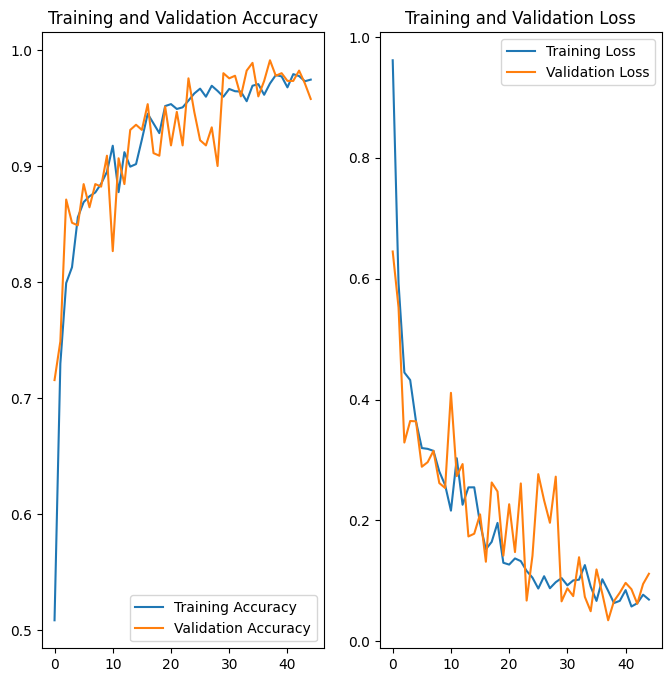

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Run prediction on a sample image**

first image to predict
actual label: Tomato_healthy
1/1 [==============================] - 0s 233ms/step
predicted label: Tomato_healthy


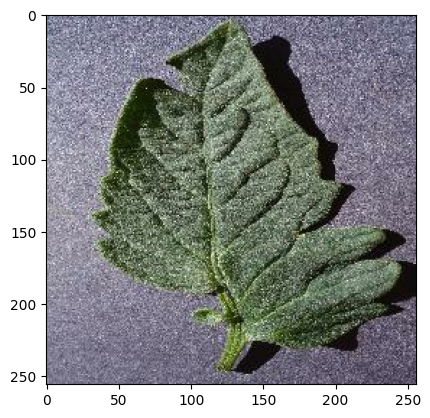

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 18ms/step


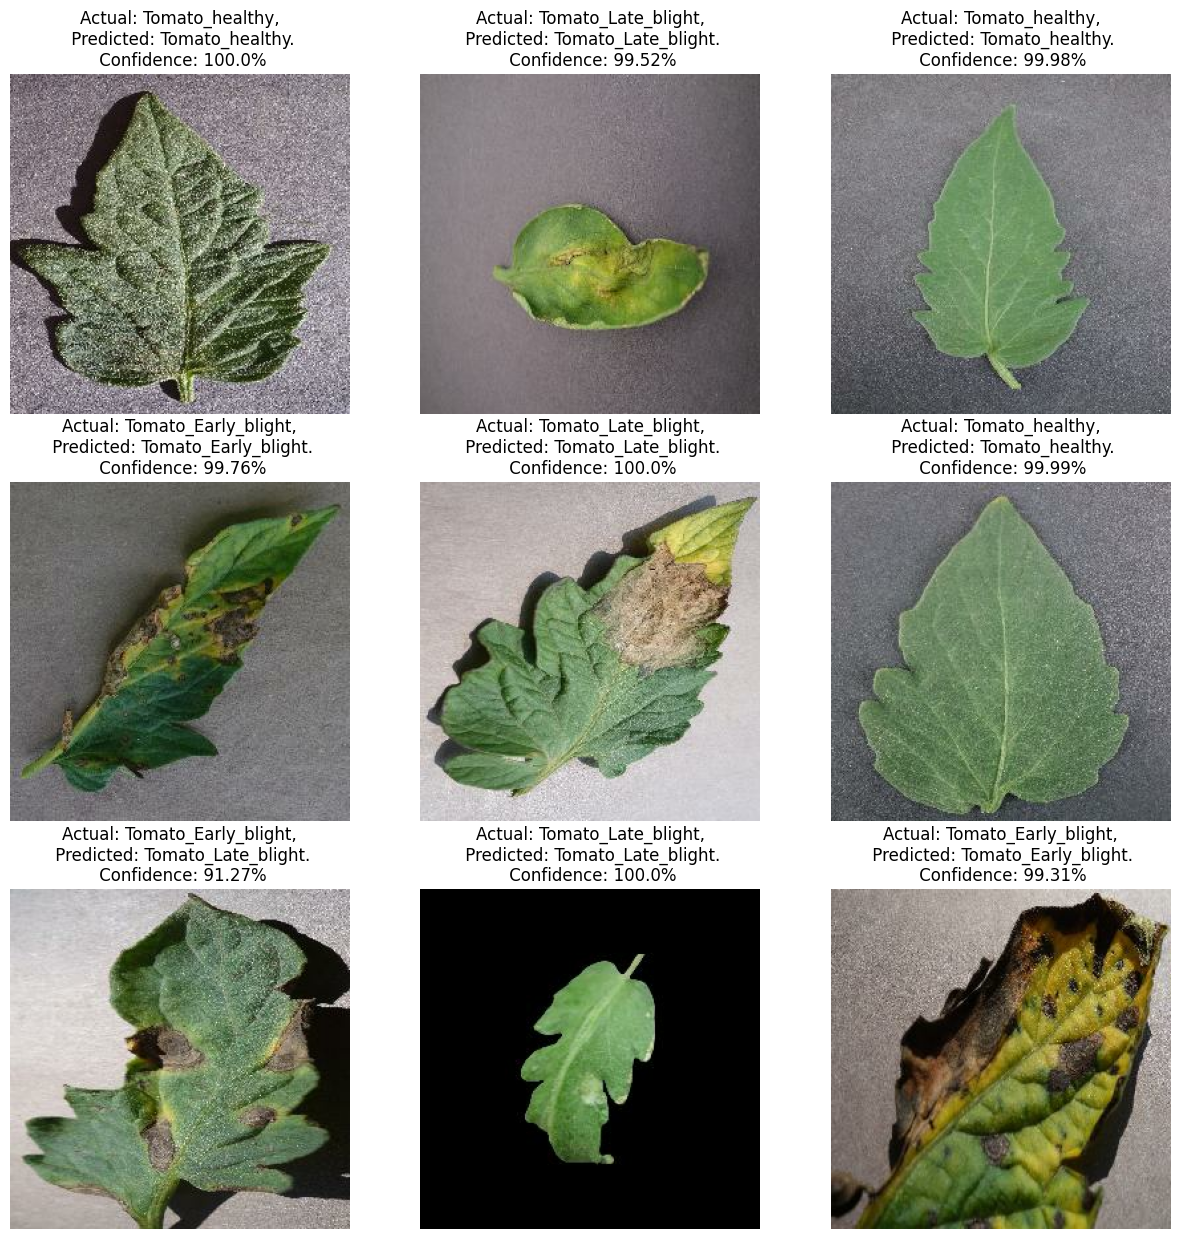

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")